# Prepare sentences to validate

This notebook uses the files `results/ExTRI2_final_resource.tsv` and `data/tmp/ExTRI2_nonvalid_subset.tsv` to get a subset of sentences to validate.<br>
These files are created by the file `scripts/postprocessing/prepare_ExTRI2_resource.ipynb`

In [1]:
__import__('sys').path.append('../common/'); __import__('notebook_utils').table_of_contents('prepare_validation_results.ipynb')

<h3>Table of contents</h3>


[Prepare sentences to validate](#Prepare-sentences-to-validate)
- [Setup](#Setup)
- [Explanation of the validation process](#Explanation-of-the-validation-process)
- [Get the final validation datasets](#Get-the-final-validation-datasets)
  - [Analysis of mismatching sentences](#Analysis-of-mismatching-sentences)
- [Creation of datasets to validate (stages 1 - 7)](#Creation-of-datasets-to-validate-(stages-1---7))
  - [Stages 1-3 validation. Validation of previous results](#Stages-1-3-validation.-Validation-of-previous-results)
  - [Stage 4 validation: random & balanced validation dataset for dbTF & coTF](#Stage-4-validation:-random-&-balanced-validation-dataset-for-dbTF-&-coTF)
  - [Stage 5 validation](#Stage-5-validation)
  - [Stage 6 validation - likely coTF sentences](#Stage-6-validation---likely-coTF-sentences)
  - [Stage 7 - Final sentences for completion](#Stage-7---Final-sentences-for-completion)
- [Excel VBA script](#Excel-VBA-script)

## Setup

In [21]:
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import os
import math

## Custom functions
import sys
sys.path.append('../common')
from notebook_utils import table_of_contents, table_from_dict, h3, h4, h5, md
from validation import *

pd.set_option('display.max_colwidth', 20)

In [22]:
# UNCOMMENT TO REIMPORT A CERTAIN FUNCTION AFTER MODIFYING ITS CODE
import importlib 
import validation
importlib.reload(validation)
from validation import *

In [23]:
# Dataframes
config = load_config()

# Load validated sentences pre and post normalisation
TRI_df, nonTRI_df = load_TRI_nonTRI_df(config['final_ExTRI2_p'], config['nonvalid_sample_p'], config['training_data_p'])
TRI_df_prerenorm, nonTRI_df_prerenorm = load_TRI_nonTRI_df(config['valid_pre_renorm_p'], config['nonvalid_sample_p'], config['training_data_p'])

all_df = pd.concat([TRI_df, nonTRI_df], ignore_index=True)
# validated_df = join_all_validated_dfs(config)

# Set of all TF IDs
with open(config['tf_ids_p'], "r") as f:
    tf_ids = {l.strip("\n") for l in f}

Training PMIDs:	 We used 8928 PMIDs in the training set, that we will filter out for validation.
Training PMIDs:	 We used 8928 PMIDs in the training set, that we will filter out for validation.


In [24]:
# DISPLAY FUNCTIONS
def plot_bar_chart(ax: plt.axes, counts, ylabel, title):
    # ax.bar(counts[:20].index, counts[:20])
    # ax.set_xticklabels(counts[:20].index, rotation='vertical')

    ax.bar(counts.index[:200], counts[:200])
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_ylabel(ylabel)
    ax.set_xlabel("TFs ordered by frequency")

def plot_counts_side_by_side(suptitle, df1, df2, title1, title2, ylabel=None, ylabel1=None, ylabel2 = None):
    counts1 = df1['TF Id'].value_counts()
    counts2 = df2['TF Id'].value_counts()

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # Create 1 row, 2 columns of subplots

    # Plot each DataFrame using the helper function
    if ylabel is not None:
        ylabel2 = ylabel1 = ylabel
    plot_bar_chart(axes[0], counts1, ylabel1, title1)
    plot_bar_chart(axes[1], counts2, ylabel2, title2)

    #plt.xticks(rotation='vertical')
    plt.suptitle(suptitle)
    plt.tight_layout()
    plt.show()

def show_validation_distribution(ax, tf_type: str, all_sents: pd.DataFrame, val_random: pd.DataFrame, val_balanced: pd.DataFrame):
    '''
    Show the distribution of the balanced and random coTFs in comparison to the full set of obtained sentences
    '''
    for df, label, color, alpha in [
        (all_sents, "All sentences", "grey", 0.2),
        (val_balanced, 'Balanced', "blue", 1),
        (val_random, "Randomly validated", "green", 1)
    ]:
        counts = df['TF Id'].value_counts()
        ax.bar(counts.index, counts, label=label, color=color, alpha=alpha, width=1)
    ax.set_title(tf_type)
    ax.set_xticks([])
    #plt.xticks(rotation='vertical')
    ax.set_ylabel(f"Number of Sentences with that {tf_type}")
    ax.set_xlabel(f"{tf_type}s ordered by frequency")
    ax.set_ylim((0,30))
    ax.legend()

## Explanation of the validation process

The validation has been done on different stages as the project advanced. During this time, ExTRI2 pipeline has been run 3 times with 3 independently trained models. As such, the resulting validated results must be mapped to the final ExTRI2 results to reach the final accuracy of the model. Each stage has ensured not to repeat previously validated sentences. The validations done in each stage are shown below.

As sentences from Stage 1 and 2 were validated from a previous ExTRI2 resource version, they will be cross-validated with the actual ExTRI2 resource, as the model's predictions on some sentences might have changed in between runs.

In [25]:
# Summary of the different stages

raw_validated_df = join_all_validated_dfs(config)

raw_validated_df['global_stage'] = raw_validated_df['stage'].map({"s1": "dbTF_PoC", 
                   "s2": "dbTF_1st_run", "s3": "dbTF_1st_run",
                   "s4_dbTF": "dbTF_2nd_run", 
                   "s4_coTF": "coTF_2nd_run", "s5_coTF": "coTF_2nd_run",
                   "s6_coTF": "coTF_2nd_run", "s6_coTF_ll": "coTF_ll_2nd_run",})
raw_validated_df['category'] = raw_validated_df['method']
raw_validated_df.loc[raw_validated_df['Label'] == 'FALSE', 'category'] = 'False'

display(raw_validated_df.pivot_table(index='category', columns='global_stage', aggfunc='size', fill_value=0))
display(raw_validated_df.pivot_table(index='category', columns='TF_type', aggfunc='size', fill_value=0))

# display(validated_df['TF_type'].value_counts())

302 and 244 rows have been removed from the stage 4 & 5 validated datasets respectively as they were not validated.
20 sentences have been dropped because they contained missing values.
15 duplicated sentences have been dropped as they were validated in more than one stage.


global_stage,coTF_2nd_run,coTF_ll_2nd_run,dbTF_1st_run,dbTF_2nd_run,dbTF_PoC
category,,,,,
False,170,100,200,0,99
balanced,841,142,0,1362,0
random,691,500,797,0,444


TF_type,coTF,dbTF,ll_coTF
category,,,
False,170,299,100
balanced,950,1590,309
random,691,1241,500


Further information:
* Proof of concept run on 10% of PubMed
    * Stage 1: 550 randomly selected dbTF sentences, 50 of which mutated, and 100 false.
* First full run on all PubMed
    * Stage 2: 400 randomly selected dbTF sentences, 0 false.
    * Stage 3: 600 randomly selected dbTF sentences, 200 false.
* Second full run on all PubMed:
    * Stages 4-6

## Get the final validation datasets

In [26]:
# 1. Join all validated dfs into 1
raw_validated_df = join_all_validated_dfs(config)

# 2. Join validated_df with prerenorm_df (keeping all unequal columns)
merged_df_valid, non_merged_df = join_validated_df_with_TRI_df(raw_validated_df, TRI_df_prerenorm)

# 3. Join validated_df with ExTRI2_df (keeping all unequal columns)
merged_df_false, non_merged_df_2 = find_remaining_validated_in_candidate_sents(non_merged_df, config, chunk_size=1_000_000)

# 4. Join all the dataframes
final_validated_df = get_final_validated_df(merged_df_valid.copy(), merged_df_false.copy(), TRI_df)

# 5. Only keep validated sentences where TF has 1 mapping
def get_1mapping_df(validated_df, TRI_df):
    '''
    Return only those sentences with TF mapped to only 1 ID
    Print the number of sentences discarded
    '''

    # Multiple IDs are connected by ;. Make masks
    m_ExTRI = TRI_df['TF Id'].str.contains(';')
    m_val = validated_df['TF Id'].str.contains(';') & ~validated_df['#SentenceID'].duplicated()

    # Display how many sentences are mapped to multiple TF IDs
    print(f"{m_ExTRI.sum() / len(TRI_df):.2%} of the sentences in the ExTRI2 dataset are not considered for validation as their TF has multiple mappings to Gene IDs.")
    print(f"We will discard those sentences in the validated dataset with multiple mappings: {m_val.sum()} ({m_val.sum() / len(validated_df['#SentenceID'].unique()):.2%}) sentences: "\
        f"most of them ({(m_val & (validated_df['method'] == 'balanced')).sum()}) from the balanced subset")

    # Remove sentences with multiple TF mappings
    validated_1mapping = validated_df[~validated_df['TF Id'].str.contains(';')]
    TRI_1mapping = TRI_df[~TRI_df['TF Id'].str.contains(';')]
    assert (validated_1mapping['TF_type'] == validated_1mapping['TF_type_validated']).all()

    return validated_1mapping, TRI_1mapping

validated_1mapping, TRI_1mapping = get_1mapping_df(final_validated_df, TRI_df)

# 6. Balance the validation dataset
def adjust_balanced_subset(ExTRI2_df: pd.DataFrame, validated_df_1mapping: pd.DataFrame) -> pd.DataFrame:
    """
    Adjusts the balanced subset of validated_df by adding or removing sentences
    to ensure a consistent number of sentences per batch for each TF type.

    Only takes TFs that have been mapped to 1 only TF Id
    """

    # Sentences to add and to remove from the balanced dataset
    idx_to_add = []
    idx_to_remove = []

    for TF_type, TRI_size in (('dbTF', 1000), ('coTF', 500), ('ll_coTF', 500)):

        # Get the subsets of the ExTRI2 and validated datasets
        TRI_subset = ExTRI2_df[ExTRI2_df['TF_type'] == TF_type]
        val_subset = validated_df_1mapping[validated_df_1mapping['TF_type'] == TF_type]

        # Separate the random and balanced subsets
        val_subset_b = val_subset[val_subset['method'] == 'balanced']
        val_subset_r = val_subset[val_subset['method'] == 'random']

        # Get the TF IDs in the ExTRI2 dataset ordered by counts
        sorted_retrieved_TFs = TRI_subset['TF Id'].value_counts().index
        
        # Get number of sentences, with different TFs, that will be drawn from each batch
        TFs_drawn_per_batch = 2

        # Calculate the number of TFs to be included in each batch
        batch = math.ceil(len(sorted_retrieved_TFs) / TRI_size) * TFs_drawn_per_batch

        # Get a set of random sentences to add to or subtract from the balanced dataset (if needed)
        for i in range(0, len(sorted_retrieved_TFs), batch):
            
            # Get the batch of TFs
            TFs_subset = set(sorted_retrieved_TFs[i:i+batch])

            # Get corresponding sentences from the balanced subset
            TFs_subset_b = val_subset_b[val_subset_b['TF Id'].isin(TFs_subset)]

            # Identify duplicates based on 'TF Id' and save their indexes
            m_duplicated_TF = TFs_subset_b.duplicated(subset='TF Id', keep='first')

            # Remove duplicates from the balanced subset
            idx_to_remove.extend(TFs_subset_b[m_duplicated_TF].index.tolist())

            # Drop duplicates from TFs_subset_b to keep only one sentence per TF
            TFs_subset_b = TFs_subset_b[~m_duplicated_TF]
            assert TFs_subset_b['TF Id'].nunique() == len(TFs_subset_b)


            if len(TFs_subset_b) > TFs_drawn_per_batch:
                # If there are too many sentences, calculate how many to remove
                num_to_remove = len(TFs_subset_b) - TFs_drawn_per_batch
                # Collect the excess sentences to remove
                idx_to_remove.extend(TFs_subset_b.sample(n=num_to_remove).index.tolist())

            elif len(TFs_subset_b) < TFs_drawn_per_batch:
                # If there are too few sentences, calculate how many to add
                num_to_add = TFs_drawn_per_batch - len(TFs_subset_b)

                # Remove from TFs subset those that are already in the balanced dataset (if any)
                TFs_subset = TFs_subset.difference(set(TFs_subset_b['TF Id']))

                # Get sentences from the random subset to add
                TFs_subset_r = val_subset_r[val_subset_r['TF Id'].isin(TFs_subset)]

                # Ensure we don't add the same TF twice
                unique_TFs_subset_r = TFs_subset_r.drop_duplicates(subset='TF Id', keep='first')

                idx_to_add.extend(unique_TFs_subset_r.sample(n=min(num_to_add, len(unique_TFs_subset_r))).index.tolist())

    # Show how many sentences will be added and removed
    print(f"{len(idx_to_remove)} sentences will be removed from the balanced subset")
    print(f"{len(idx_to_add)} sentences will be added to the balanced subset")

    # Ensure we're adding and removing the expected sentences
    for method, idx in zip(['random', 'balanced'], [idx_to_add, idx_to_remove]):
        assert set(validated_df_1mapping.loc[idx]['method']) == {method}

    # Remove excess sentences from the balanced subset
    validated_df_1mapping = validated_df_1mapping.drop(index=idx_to_remove)

    # Add the selected random sentences to the balanced subset
    sents_to_add = validated_df_1mapping.loc[idx_to_add].copy().reset_index(drop=True)
    sents_to_add['method'] = 'balanced'
    validated_df_1mapping = pd.concat([validated_df_1mapping, sents_to_add]).reset_index(drop=True)

    return validated_df_1mapping

# Fix the balanced subset for validation datasets pre and post preprocessing rules, and false sentences
validated_1mapping_post = validated_1mapping[(validated_1mapping['pre-post'] == 'post') & (validated_1mapping['Label'] == 'TRUE')]
validated_1mapping_post = adjust_balanced_subset(TRI_1mapping, validated_1mapping_post)

validated_1mapping_pre = validated_1mapping[(validated_1mapping['pre-post'] == 'pre') & (validated_1mapping['Label'] == 'TRUE')]
validated_1mapping_pre = adjust_balanced_subset(TRI_1mapping, validated_1mapping_pre)

validated_1mapping_false = validated_1mapping[validated_1mapping['Label'] == 'FALSE']
validated_1mapping_false['pre-post'].value_counts()

# 7. Create the final adapted dataset
validated_1mapping = pd.concat([validated_1mapping_pre, validated_1mapping_post, validated_1mapping_false], ignore_index=True)

# 8. Save the final dataset
validated_1mapping.to_csv(config['final_validated_p'], sep = '\t', index=False)

302 and 244 rows have been removed from the stage 4 & 5 validated datasets respectively as they were not validated.
20 sentences have been dropped because they contained missing values.
15 duplicated sentences have been dropped as they were validated in more than one stage.
4307/5850 rows are merged.

1488/1543 rows are merged.om the candidate sentences
TF Id_prerenorm  TF Id_validated  TF Symbol_prerenorm  TF Symbol_validated
Complex:NFKB     18033            NFKB                 Nfkb1                  9
Complex:AP1      24516            AP1                  Jun                    1
Complex:NFKB     309165           NFKB                 Rela                   1
Name: count, dtype: int64
3991/4307 rows are merged.

2.03% of the sentences in the ExTRI2 dataset are not considered for validation as their TF has multiple mappings to Gene IDs.
We will discard those sentences in the validated dataset with multiple mappings: 602 (12.37%) sentences: most of them (567) from the balanced subset


### Analysis of mismatching sentences

In [27]:
# 5. Understand why some sentences have note been matched

def find_sents_with_PMID(PMIDs) -> pd.DataFrame:

    found_sents_list = []

    for i, chunk in enumerate(candidate_sents):
        chunk_pmids = chunk['#SentenceID'].apply(lambda row: row.split(':')[1])
        found_PMIDs = PMIDs.intersection(set(chunk_pmids))

        if len(found_PMIDs) > 0:
            found_sents_list.append(chunk[chunk_pmids.isin(found_PMIDs)])

    found_sents = pd.concat(found_sents_list)
    found_sents['PMID'] = found_sents['#SentenceID'].apply(lambda row: row.split(':')[1])
    found_sents['#SentenceID'] = found_sents['#SentenceID'].apply(lambda row: ":".join(row.split(':')[i] for i in [1, 4, 5, 6]))
    
    return found_sents

def highlight_differences(text1, text2):
    '''Function to highlight differences using SequenceMatcher'''
    # Use SequenceMatcher to get matching blocks
    matcher = difflib.SequenceMatcher(None, text1, text2)
    result = []

    for tag, i1, i2, j1, j2 in matcher.get_opcodes():
        if tag == 'equal':
            result.append(text1[i1:i2])  # Append the equal parts
        elif tag == 'replace':
            result.append(f'<span style="color:red; font-weight:bold;">{text2[j1:j2]}</span>')  # Highlight replacement
        elif tag == 'delete':
            result.append(f'<span style="color:blue; text-decoration:line-through; font-weight:bold;">{text1[i1:i2]}</span>')  # Highlight deleted text (from text1)
        elif tag == 'insert':
            result.append(f'<span style="color:green; font-weight:bold;">{text2[j1:j2]}</span>')  # Highlight inserted text (in text2)

    return ''.join(result)

def similarity_ratio(text1, text2):
    matcher = difflib.SequenceMatcher(None, text1, text2)
    return matcher.ratio()

def display_sentence_mismatches(non_merged_df_2, found_sents, rows_to_show=5):
    '''Merge the two dataframes and display the difference between the columns 'Text' (the candidate text) and 'Sentence' (the validated sentence)'''

    # Merge solely on #SentenceID (each sentence will have several candidate text matches this way)
    df = pd.merge(non_merged_df_2, found_sents, on=['#SentenceID'], how='inner')

    # Create columns to highlight difference between sentences & similarity between them
    df['Highlighted_Diff'] = df.apply(lambda row: highlight_differences(row['Sentence'], row['Text']), axis=1)
    df['Similarity_Ratio'] = df.apply(lambda row: similarity_ratio(row['Sentence'], row['Text']), axis=1)

    # For each Sentence, pick the row with the highest similarity ratio (i.e., least different)
    df_least_diff = df.loc[df.groupby('Sentence')['Similarity_Ratio'].idxmax()]

    # Display in HTML format
    md("Difference between the Sentence in the Validated sentences (Sentence) and that in the ExTRI2 candidate sentences (Text):")
    display(HTML(df_least_diff[['Highlighted_Diff', 'Sentence', 'Text']][:rows_to_show].to_html(escape=False)))
    return

deprecated_tf_id = ~non_merged_df_2['TF Id'].isin(tf_ids)

print(f"""
There are {len(non_merged_df_2)} sentences we can't find in the candidate sentences.
{(deprecated_tf_id).sum()} are due to TF IDs no longer considered in the last iteration.
{(non_merged_df_2['stage'] == 's4_dbTF').sum()} are in the s4_dbTF stage.
""")

# Get a list of the candidate sentences with PMIDs from the mismatches
candidate_sents = pd.read_csv(config['raw_ExTRI2_p'], sep='\t', header=1, chunksize=1_000_000, keep_default_na=False)
non_merged_df_2['PMID'] = non_merged_df_2['#SentenceID'].apply(lambda row: row.split(':')[0])

unmerged_sents_PMIDs = set(non_merged_df_2[(~deprecated_tf_id)]['PMID'])
found_sents = find_sents_with_PMID(unmerged_sents_PMIDs)

# Print not found PMIDs (issue solved)
print("PMIDs not found in the candidate sentences:")
lost_PMIDs = unmerged_sents_PMIDs.difference(set(found_sents['PMID']))
print(lost_PMIDs)

import difflib
from IPython.display import display, HTML

print("\nThe other mismatching sentences are due to validated Sentence missing characters:")
display_sentence_mismatches(non_merged_df_2, found_sents, rows_to_show=5)


There are 55 sentences we can't find in the candidate sentences.
28 are due to TF IDs no longer considered in the last iteration.
29 are in the s4_dbTF stage.

PMIDs not found in the candidate sentences:
set()

The other mismatching sentences are due to validated Sentence missing characters:


Difference between the Sentence in the Validated sentences (Sentence) and that in the ExTRI2 candidate sentences (Text):

,Highlighted_Diff,Sentence,Text
29,Adult [TF](+/-) mice display glucose intolerance due to defects in glucose-stimulated insulin secretion associated with reduced Pdx1 and Clec16a expression in [TG](+/-) islets.,Adult [TF]() mice display glucose intolerance due to defects in glucose-stimulated insulin secretion associated with reduced Pdx1 and Clec16a expression in [TG]() islets.,Adult [TF](+/-) mice display glucose intolerance due to defects in glucose-stimulated insulin secretion associated with reduced Pdx1 and Clec16a expression in [TG](+/-) islets.
37,"Analysis of splenocytes isolated from KLF13(-/-) mice revealed an increase in the expression of CD21 and CD23 on B220(+) B cells, demonstrating a negative regulatory role for [TF] in co-regulation of expression of [TG] and CD23.","Analysis of splenocytes isolated from KLF13(-/-) mice revealed an increase in the expression of CD21 and CD23 on B220() B cells, demonstrating a negative regulatory role for [TF] in co-regulation of expression of [TG] and CD23.","Analysis of splenocytes isolated from KLF13(-/-) mice revealed an increase in the expression of CD21 and CD23 on B220(+) B cells, demonstrating a negative regulatory role for [TF] in co-regulation of expression of [TG] and CD23."
54,"At the protein and transcript level, the resulting [TF] induced sensory neurons (NGN2iSNs) express sensory neuron markers such as BRN3A (82% BRN3A+ cells), [TG] (91% ISLET1+ cells), TRKA, TRKB, and TRKC.","At the protein and transcript level, the resulting [TF] induced sensory neurons (NGN2iSNs) express sensory neuron markers such as BRN3A (82% BRN3A cells), [TG] (91% ISLET1 cells), TRKA, TRKB, and TRKC.","At the protein and transcript level, the resulting [TF] induced sensory neurons (NGN2iSNs) express sensory neuron markers such as BRN3A (82% BRN3A+ cells), [TG] (91% ISLET1+ cells), TRKA, TRKB, and TRKC."
9,"Consistent with these findings, the H3K4Me3 levels at the promoters of IGFBP3, DNAJC12, [TG] and GDF15 were lower in VHL-/- cells than in VHL+/+ cells, and the differences disappeared after [TF] depletion.","Consistent with these findings, the H3K4Me3 levels at the promoters of IGFBP3, DNAJC12, [TG] and GDF15 were lower in VHL-/- cells than in VHL cells, and the differences disappeared after [TF] depletion.","Consistent with these findings, the H3K4Me3 levels at the promoters of IGFBP3, DNAJC12, [TG] and GDF15 were lower in VHL-/- cells than in VHL+/+ cells, and the differences disappeared after [TF] depletion."
50,"Furthermore, [TF] suppressed the Wnt/beta-catenin pathway through transcriptionally silencing the expression of [TG], and the promoter region (-1161 bp to +27 bp) was crucial for its inhibitory activity.","Furthermore, [TF] suppressed the Wnt/beta-catenin pathway through transcriptionally silencing the expression of [TG], and the promoter region (-1161 bp to bp) was crucial for its inhibitory activity.","Furthermore, [TF] suppressed the Wnt/beta-catenin pathway through transcriptionally silencing the expression of [TG], and the promoter region (-1161 bp to +27 bp) was crucial for its inhibitory activity."


## Creation of datasets to validate (stages 1 - 7)

### Stages 1-3 validation. Validation of previous results

In [ ]:
# TODO - Add the preparation of the validation of the previous 3 stages too here

### Stage 4 validation: random & balanced validation dataset for dbTF & coTF

Up until now, we have validated obtaining a random sample from all the sentences. However, that makes some TFs (the most frequent ones) appear a lot. We want to know whether the results are biased depending on the frequency of the TF: whether less frequent TFs get more errors more commonly.

For that, we will select rows to validate so that all TFs have the same probability of being evaluated.

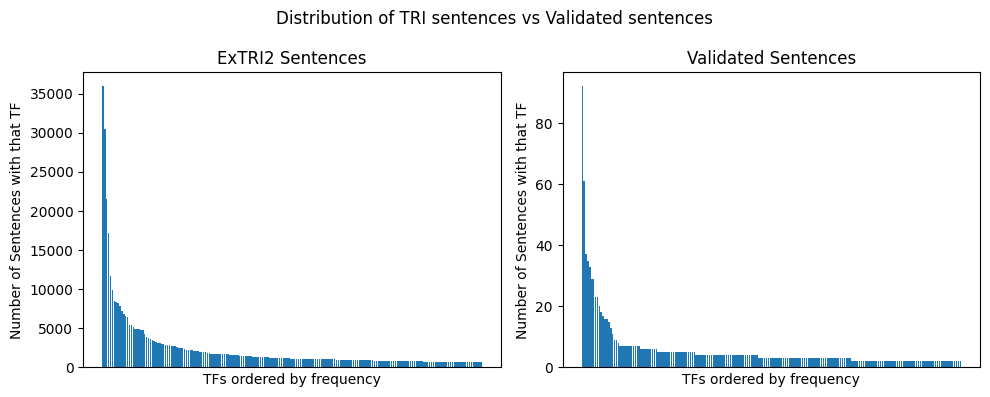

In [ ]:
# Plot the most common dbTFs side by side
stage1_3_validated = pd.concat([raw_validated_df[raw_validated_df['stage'] == stage] for stage in ['s1', 's2', 's3']], axis=0)

suptitle = "Distribution of TRI sentences vs Validated sentences"
plot_counts_side_by_side(suptitle, TRI_df, stage1_3_validated, "ExTRI2 Sentences", "Validated Sentences", ylabel="Number of Sentences with that TF")

In [ ]:
valid_dbTF = TRI_df[TRI_df['TF_type'].str.contains('dbTF')]
valid_coTF = TRI_df[TRI_df['TF_type'].str.contains('coTF')]
all_coTF   = all_df[all_df['TF_type'].str.contains('coTF')]

# Select rows for validation
print('dbTF:')
balanced_dbTF_to_validate = select_rows_for_validation(valid_dbTF, stage1_3_validated, TRI_size = 2000, method='balanced')
print('coTF:')
random_coTF_to_validate   = select_rows_for_validation(all_coTF, method='random', TRI_size = 500, nonTRI_size = 100)
balanced_coTF_to_validate = select_rows_for_validation(valid_coTF, random_coTF_to_validate, method='balanced', TRI_size = 500)

dbTF:
We will validate 1389/1754 sentences with the balanced method
coTF:
We will validate 600 sentences with the random method
We will validate 365/486 sentences with the balanced method


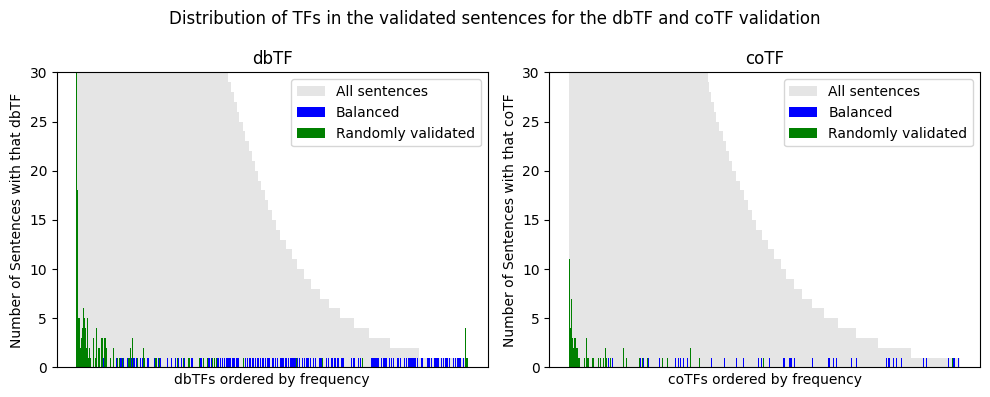

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
show_validation_distribution(axes[0], 'dbTF', valid_dbTF, val_balanced = balanced_dbTF_to_validate, val_random = stage1_3_validated)
show_validation_distribution(axes[1], 'coTF', valid_coTF, val_balanced = balanced_coTF_to_validate, val_random = random_coTF_to_validate)
plt.suptitle("Distribution of TFs in the validated sentences for the dbTF and coTF validation")

plt.tight_layout()
plt.show()

In [ ]:
# SAVE RESULTS
balanced_dbTF_to_validate.to_csv(config['stage4_balanced_dbTF_to_validate_p'], index=False, sep='\t')
balanced_coTF_to_validate.to_csv(config['stage4_random_coTF_to_validate_p'], index=False, sep='\t')
random_coTF_to_validate.to_csv(config['stage4_balanced_coTF_to_validate_p'], index=False, sep='\t')

### Stage 5 validation 
Validation of ~1000 coTFs: 500 random & 500 balanced ones, considered as "likely coTFs"

With Stage 4 validation we have come accross a lot of coTF mentions that were not coTFs. Thus, we have created a filtering that divides coTFs between likely and less likely.

Here, we create 4 more validation datasets: likely & less likely coTFs, random and balanced (~500 sentences each). The distinction is the following:

* If any of the IDs associated to the TF is present in the list of less-likely coTFs, we consider the TF to be "less likely" to be a coTF
* The list of less-likely coTFs is created by adding the human ll_coTFs with its mouse/rat orthologs.

<span style="color: brown">Validating the "likely" coTF list showed there were still a lot of "less likely" coTFs. Thus, the "less likely" coTFs of stage 5 have not been validated. Check Stage 6 to see the "less likely" coTF sentences that have been validated.</span>

In [ ]:
## FUNCTIONS
def get_HGNC_orthologs(coTF_ids: list, orthologs_path: str):
    orthologs = pd.DataFrame()

    for rodent in ['mouse', 'rat']:
        # Load dataframe
        path = os.path.join(orthologs_path, f"human_{rodent}_hcop_fifteen_column.txt")
        hgnc_df = pd.read_csv(path, sep='\t', header=0, keep_default_na=False, dtype=str)

        # Rename
        hgnc_df = hgnc_df.rename(columns={f"{rodent}_entrez_gene": "entrez_gene", f"{rodent}_symbol": "symbol"})
        
        orthologs = pd.concat([orthologs, hgnc_df])

    # Keep only IDs present in the coTF list
    orthologs = orthologs[orthologs['entrez_gene'].isin(coTF_ids)]

    # Remove all rows that don't have a human entrez ID or hgnc ID
    m = (orthologs['human_entrez_gene'] != '-') | (orthologs['hgnc_id'] != '-')
    orthologs = orthologs[m]

    # Join with ';' when an EntrezID has more than 1 human ortholog
    agg_funcs = {
        "symbol": lambda x: ';'.join(x.unique()),
        "human_entrez_gene": lambda x: ';'.join(x.unique()),
        "hgnc_id": lambda x: ';'.join(x.unique()),
        "human_symbol": lambda x: ';'.join(x.unique())
    }
    orthologs = orthologs.groupby(['entrez_gene']).agg(agg_funcs).reset_index()

    # Show how many we get
    print(f"We get ortholog info for {len(orthologs)}/{len(coTF_ids)} Gene IDs")


    # Convert into dictionary
    orthologs_map = orthologs.set_index('entrez_gene').to_dict(orient='index')

    return orthologs_map

In [ ]:
# THIS CODE IS OUTDATED - This file is outdated and is not used in the final version. It is kept here for reproducibility purposes
data_path = '../../data/'
ll_human_coTFs_path = data_path + 'postprocessing/all_human_ortholog_coTFs_labelled_less_likely.txt'
orthologs_path               = data_path + 'external/human_HGNC_orthologs/'

# FIX THE EXTRI2 DATAFRAME
# Get the human orthologs of the coTFs in ExTRI2
m_r_coTFs_in_ExTRI2 = set(TRI_df[(TRI_df['TF_type'] == 'coTF') & (TRI_df['TF TaxID'] != '9606')]['TF Id'])
m_r_coTFs_in_ExTRI2 |= set(all_df[(all_df['TF_type'] == 'coTF') & (all_df['TF TaxID'] != '9606')]['TF Id'])

orthologs_map = get_HGNC_orthologs(m_r_coTFs_in_ExTRI2, orthologs_path)

# Get the set of the human IDs less likely to be coTFs

human_coTFs_labelled = pd.read_csv(ll_human_coTFs_path, sep='\t', header=0, dtype='str')
h_ll_coTFs = set(human_coTFs_labelled[human_coTFs_labelled['less likely'] == 'less likely']['NCBI ID'])

# Get the set of mouse/rat IDs with human IDs in the previous list
m_r_ll_coTFs = set()
for id, v in orthologs_map.items():
    if any([(h_id in h_ll_coTFs) for h_id in v['human_entrez_gene'].split(';')]):
        m_r_ll_coTFs.add(id)

# Join both sets & filter the ExTRI2 dataset to only contain IDs outside this set
ll_coTFs = m_r_ll_coTFs | h_ll_coTFs
# Add the mouse/rat coTFs w/o human orthologs but not likely to be coTFs / retired
ll_coTFs.update({'100910506', '108348112'})

We get ortholog info for 1747/1750 Gene IDs


In [ ]:
# GET SENTENCES TO VALIDATE
# Consider as coTFs all those that have coTFs but not dbTF mentions
valid_coTF = TRI_df[(TRI_df['TF_type'].str.contains('coTF')) & ~(TRI_df['TF_type'].str.contains('dbTF'))].copy()
all_coTF = all_df[(all_df['TF_type'].str.contains('coTF')) & ~(all_df['TF_type'].str.contains('dbTF'))].copy()

def id_in_list(IDs, TF_set):
    return any([id in TF_set for id in IDs.split(';')])

# Rename TF_type to 'coTF_unlikely' for cases where any ll coTF is found.
# WARNING - For the final version, we have replaced all instances of 'coTF_unlikely' by 'll_coTF'. This code remains unchanged for reproducibility
m = valid_coTF['TF Id'].apply(lambda ids: id_in_list(ids, ll_coTFs))
valid_coTF.loc[m, 'TF_type'] = 'coTF_unlikely'

m = all_coTF['TF Id'].apply(lambda ids: id_in_list(ids, ll_coTFs))
all_coTF.loc[m, 'TF_type'] = 'coTF_unlikely'

# Separate likely coTFs from ll coTF ones
m = valid_coTF['TF_type'] == 'coTF_unlikely'
valid_ll_coTF = valid_coTF[m]
valid_likely_coTF = valid_coTF[~m]

m = all_coTF['TF_type'] == 'coTF_unlikely'
all_ll_coTF = all_coTF[m]
all_likely_coTF = all_coTF[~m]

# Get previous coTF validated sentences
stage4_coTF_validated = pd.read_csv(config['stage4_coTF_validated_p'], sep='\t')

# Select rows for validation
random_likely_coTF_to_validate   = select_rows_for_validation(all_likely_coTF, stage4_coTF_validated, method='random', TRI_size = 400, nonTRI_size = 100)
balanced_likely_coTF_to_validate = select_rows_for_validation(valid_likely_coTF, pd.concat([random_likely_coTF_to_validate, stage4_coTF_validated], axis=0), method='balanced', TRI_size = 500)

random_ll_coTF_to_validate   = select_rows_for_validation(all_ll_coTF, stage4_coTF_validated, method='random', TRI_size = 400, nonTRI_size = 100)
balanced_ll_coTF_to_validate = select_rows_for_validation(valid_ll_coTF, pd.concat([random_ll_coTF_to_validate, stage4_coTF_validated], axis=0), method='balanced', TRI_size = 500)

# Join
likely_coTF_to_validate = pd.concat([random_likely_coTF_to_validate, balanced_likely_coTF_to_validate], axis=0)
ll_coTF_to_validate = pd.concat([random_ll_coTF_to_validate, balanced_ll_coTF_to_validate], axis=0)

We will validate 500 sentences with the random method
We will validate 330/441 sentences with the balanced method
We will validate 500 sentences with the random method
We will validate 236/294 sentences with the balanced method


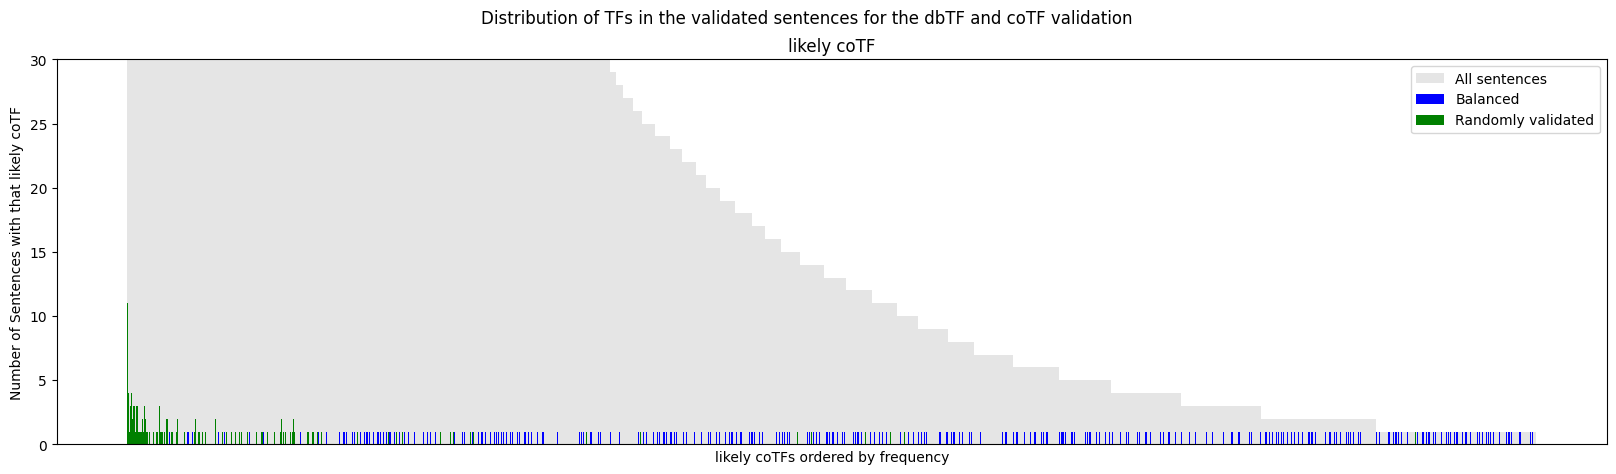

In [ ]:
# PLOT
fig, axes = plt.subplots(1, 1, figsize=(20, 5))
show_validation_distribution(axes, 'likely coTF', valid_likely_coTF, val_balanced = balanced_likely_coTF_to_validate, val_random = random_likely_coTF_to_validate)
plt.suptitle("Distribution of TFs in the validated sentences for the dbTF and coTF validation")
plt.show()

In [ ]:
# SAVE RESULTS
# Only likely were validated. The ll_coTF were validated in stage 6 as in stage 5 the ll_coTF list used was lacking.
likely_coTF_to_validate.to_csv(config['stage5_likely_coTF_to_validate_p'], index=False, sep='\t')

### Stage 6 validation - likely coTF sentences
Validation of more coTF sentences 

Using the updated list of non-likely coTFs, we will create a new set of sentences to be validated.

In [ ]:
# GET LESS LIKELY coTFs
likely_coTFs_path    = '../../data/postprocessing/all_coTFs_likely_checked_updated_AL.txt'

def load_check_likely_coTFs(likely_coTFs_path):
    '''
    Load the likely coTFs & check its integrity
    '''
    likely_coTFs = pd.read_csv(likely_coTFs_path, sep='\t', header=0, dtype='str')

    # Check less likely distribution
    m = likely_coTFs['likely'] == 'less likely'
    print(f"{m.sum()}/{len(likely_coTFs)} coTFs are marked as less likely to be coTFs.")

    # Ensure there are no symbols with the "likely" tag that also have the "less likely" tag in other species
    assert likely_coTFs[m]['NCBI Symbol'].str.upper().isin(set(likely_coTFs[~m]['NCBI Symbol'].str.upper())).sum() == 0, "Likely & less likely symbols have overlap"

    return likely_coTFs


# Load likely coTFs & create sets for their IDs and Symbols
# Get the set of IDs and Symbols that are less likely to refer to a coTF
likely_coTFs = load_check_likely_coTFs(likely_coTFs_path)
ll_coTFs_id = set(likely_coTFs[m]["NCBI ID"])
ll_coTFs_symb = set(likely_coTFs[m]["NCBI Symbol"].str.upper().unique())



454/4583 coTFs are marked as less likely to be coTFs.


In [ ]:
# Get dfs for the rows marked as less likely in previous validations
m_s4 = [stage4_coTF_validated]['Correct name'] == 'x'
s4_ll = set(stage4_coTF_validated[m_s4]['TF Id'])

stage5_coTF_validated = pd.read_csv(config['stage5_coTF_validated_p'], sep='\t')
m_s5 = stage5_coTF_validated['Valid?'].isna()
s5_ll = set(stage5_coTF_validated[m_s5]['TF Id'])

# Get all validated coTFs
coTF_validated = pd.concat([stage4_coTF_validated, stage5_coTF_validated], axis=0)
coTF_validated['Valid'] = coTF_validated['Label'].apply(lambda label: "Valid" if label=='TRUE' else "Not valid")

coTF_validated_ll = pd.concat([stage4_coTF_validated[m_s4], stage5_coTF_validated[m_s5]], axis=0)

# Ensure we get the same rows by using the symbols and IDs masks
ll_ids_m = coTF_validated_ll['TF norm'].str.upper().isin(ll_coTFs_symb)
ll_sym_m = coTF_validated_ll['TF Id'].isin(ll_coTFs_id)
assert ll_ids_m.equals(ll_sym_m), "Using symbols and IDs give different results"

# Get the Symbols marked as "less likely" in the validation but not in the list of likely coTFs
not_counted_for_ll_coTFs = set(";".join(coTF_validated_ll['TF norm'].str.upper()).split(";")).difference(ll_coTFs_symb)
print(f"{len(not_counted_for_ll_coTFs)} Symbols were marked as less likely but are considered as likely by the updated list:")
print(";".join(not_counted_for_ll_coTFs))
print("\nA manual check on them has ensured the new list (likely_coTFs) is updated: those sentences should be considered likely.")

61 Symbols were marked as less likely but are considered as likely by the updated list:
STK11;ABCC8;IL12B;TRIB3;TGFB2;CXCL8;ST3GAL5;ILF2;CAMK2G;PRKD3;IL11;KRAS;GPHA2;MYD88;PTK2B;FGF3;RPS6KA4;IGKV1D-22;PLCB2;TRIB1;FGF13;GPX1;PRRT2;BTRC;IL7;FGFR3;IL10;RPS6KA1;IL4;PRKCE;IL3;IL6;IL1A;ATM;PPRC1;IL18;FGF12;JAK1;KDR;PRKN;IL2;PPARGC1A;IL5;CDK20;IL15;IL9;AKT3;STK3;FGF9;TRAP;RASD1;BCR;SPINT2;JAK2;LGALS9;DUSP26;PRKCD;ITGB1;IL13;ECM1;RAN

A manual check on them has ensured the new list (likely_coTFs) is updated: those sentences should be considered likely.


We will validate 250 sentences with the random method
We will validate 211/788 sentences with the balanced method
We will validate 600 sentences with the random method
We will validate 142/334 sentences with the balanced method


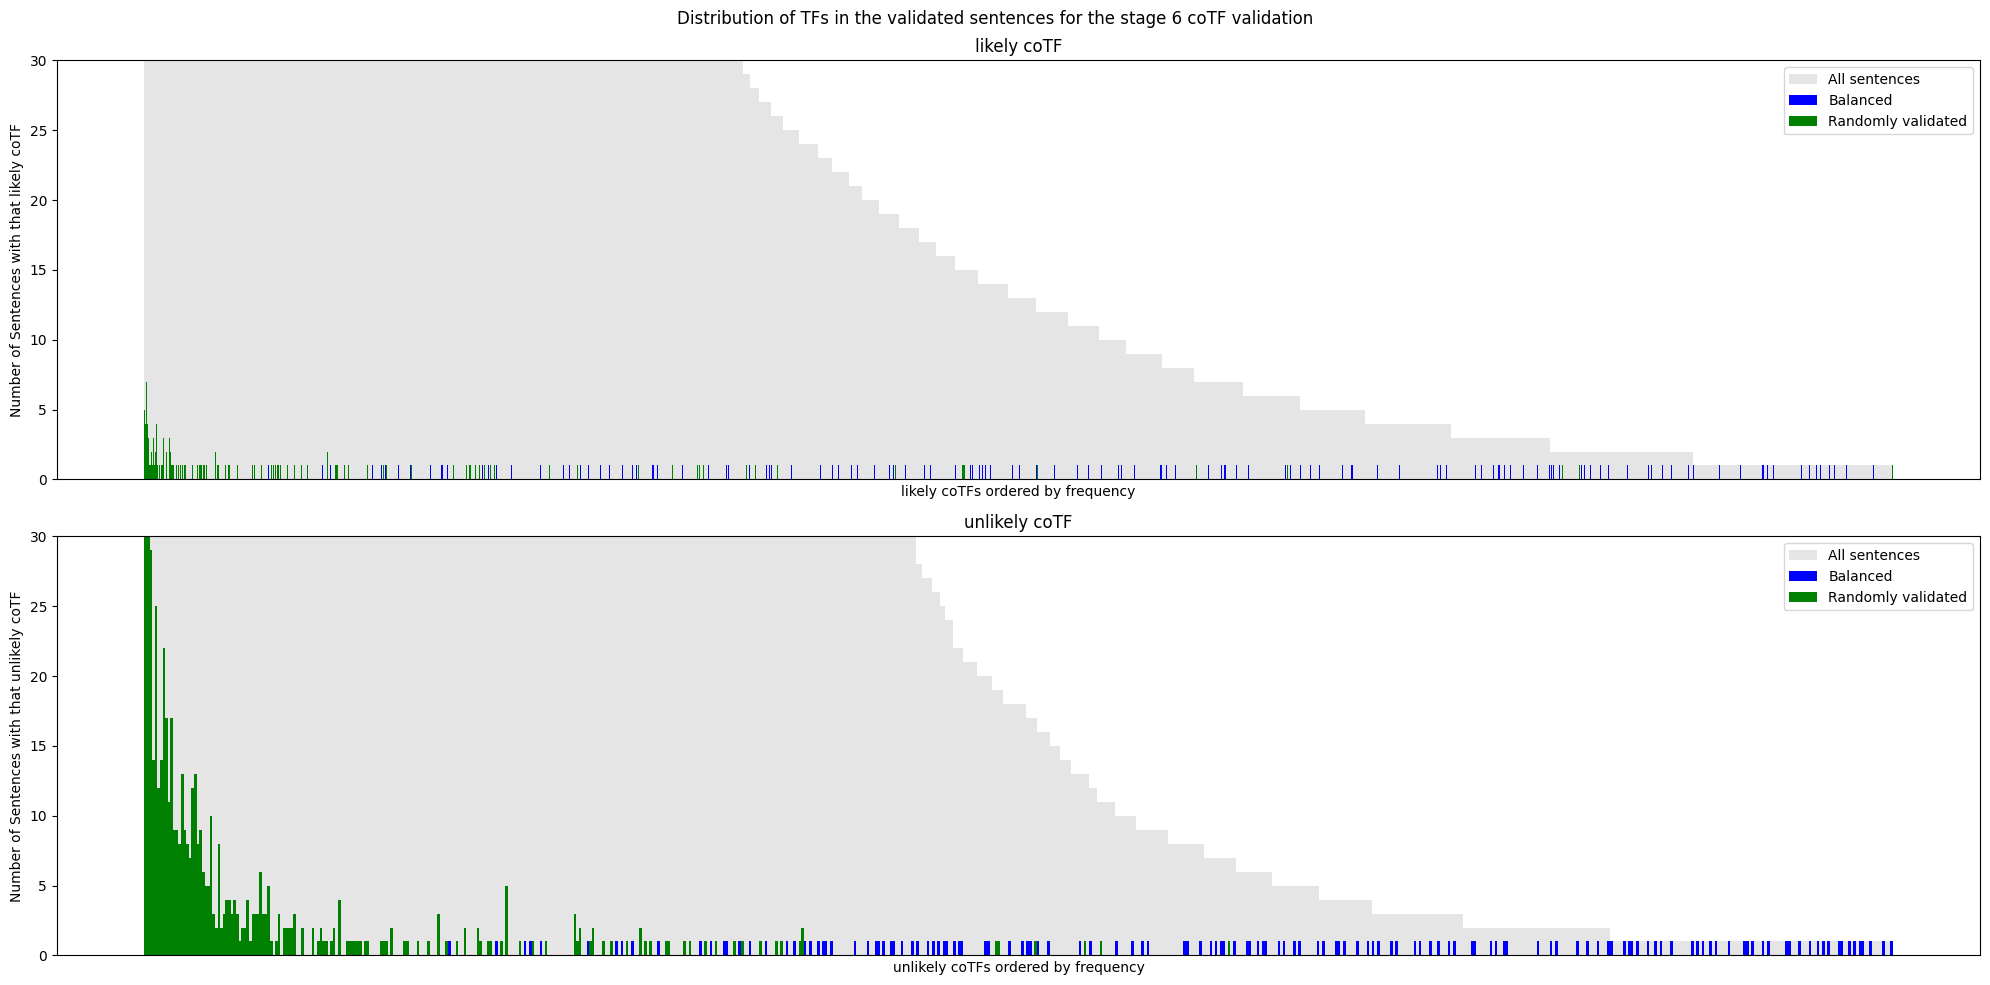

In [ ]:
# GET SENTENCES TO VALIDATE

# Consider as coTFs all those that have coTFs but not dbTF mentions
valid_coTF = TRI_df[(TRI_df['TF_type'].str.contains('coTF')) & ~(TRI_df['TF_type'].str.contains('dbTF'))].copy()
all_coTF = all_df[(all_df['TF_type'].str.contains('coTF')) & ~(all_df['TF_type'].str.contains('dbTF'))].copy()

def id_in_list(IDs, TF_set):
    return any([id in TF_set for id in IDs.split(';')])

# Rename TF_type to 'coTF_unlikely' for cases where any unlikely coTF is found.
# WARNING - For the final version, we have replaced all instances of 'coTF_unlikely' by 'll_coTF'. This code remains unchanged for reproducibility
m = valid_coTF['TF Id'].apply(lambda ids: id_in_list(ids, ll_coTFs_id))
valid_coTF.loc[m, 'TF_type'] = 'coTF_unlikely'
m = all_coTF['TF Id'].apply(lambda ids: id_in_list(ids, ll_coTFs_id))
all_coTF.loc[m, 'TF_type']   = 'coTF_unlikely'


# Separate likely coTFs from unlikely coTF ones
m = valid_coTF['TF_type'] == 'coTF_unlikely'
valid_ll_coTF = valid_coTF[m]
valid_likely_coTF = valid_coTF[~m]

m = all_coTF['TF_type'] == 'coTF_unlikely'
all_ll_coTF = all_coTF[m]
all_likely_coTF = all_coTF[~m]



# Select sentences for validation & prepare them for the Excel format
random_likely_coTF_to_validate     = select_rows_for_validation(all_likely_coTF, coTF_validated, method='random', TRI_size = 200, nonTRI_size = 50)
balanced_likely_coTF_to_validate   = select_rows_for_validation(valid_likely_coTF, pd.concat([random_likely_coTF_to_validate, coTF_validated], axis=0), method='balanced', TRI_size = 1000)
random_ll_coTF_to_validate   = select_rows_for_validation(all_ll_coTF, coTF_validated, method='random', TRI_size = 500, nonTRI_size = 100)
balanced_ll_coTF_to_validate = select_rows_for_validation(valid_ll_coTF, pd.concat([random_ll_coTF_to_validate, coTF_validated], axis=0), method='balanced', TRI_size = 500)

# Join
likely_coTF_to_validate = pd.concat([random_likely_coTF_to_validate, balanced_likely_coTF_to_validate], axis=0)
ll_coTF_to_validate = pd.concat([random_ll_coTF_to_validate, balanced_ll_coTF_to_validate], axis=0)

# Plot
fig, axes = plt.subplots(2, 1, figsize=(20, 10))
show_validation_distribution(axes[0], 'likely coTF', valid_likely_coTF, val_balanced = balanced_likely_coTF_to_validate, val_random = random_likely_coTF_to_validate)
show_validation_distribution(axes[1], 'unlikely coTF', valid_ll_coTF, val_balanced = balanced_ll_coTF_to_validate, val_random = random_ll_coTF_to_validate)

plt.suptitle("Distribution of TFs in the validated sentences for the stage 6 coTF validation")
plt.tight_layout()
plt.show()

# Save
likely_coTF_to_validate.to_csv(config['stage6_likely_coTF_to_validate_p'], index=False, sep='\t')
ll_coTF_to_validate.to_csv(config['stage6_ll_coTF_to_validate_p'], index=False, sep='\t')

### Stage 7 - Final sentences for completion
Sentences extracted from the final validation dataset

In [ ]:
final_validated_df = pd.read_csv(config['final_validated_p'], sep='\t')

# Sentences with negations will be rechecked
negations_path = config['TO_VALIDATE_P'] = 'negations.xlsl'

m = ~(final_validated_df['Other issues'].isna()) & (final_validated_df['Other issues'].str.contains('negation'))
final_validated_df[m].to_csv(negations_path, index=False, sep='\t')

# Due to dropped columns for various reasons, the balanced_dataset becomes unbalanced. Create a final balanced dataset to validate
def get_final_prenorm_norm_balanced_rows_for_validation(TRI_df, TRI_df_prerenorm, merged_df, merged_df_prerenorm, TF_type, TRI_size, save_path) -> pd.DataFrame:
    print(TF_type)

    # Get balanced prenormalized sentences
    if TF_type == 'coTF':
        xTF_df        = TRI_df_prerenorm[TRI_df_prerenorm['TF_type'].str.contains(r'(?<!ll_)coTF')] 
    else:
        xTF_df        = TRI_df_prerenorm[TRI_df_prerenorm['TF_type'].str.contains(TF_type)]

    xTF_validated = merged_df_prerenorm[merged_df_prerenorm['val TF_type'] == TF_type]
    to_validate_prenorm = select_rows_for_validation(xTF_df, xTF_validated, method='balanced', TRI_size = TRI_size, TFs_drawn_per_batch = 1)

    # Modify the column Valid by Label
    to_validate_prenorm['Label'] = to_validate_prenorm['Valid'].map({'Valid': 'TRUE', 'Non valid': 'FALSE'})
    to_validate_prenorm.drop(columns='Valid', inplace=True)
    to_validate_prenorm['stage'] = 's7_prenorm'

    # Get balanced renormalized sentences
    xTF_df        = TRI_df[TRI_df['TF_type'].str.contains(TF_type)]
    xTF_validated = pd.concat([merged_df[merged_df['val TF_type'] == TF_type], to_validate_prenorm])
    to_validate = select_rows_for_validation(xTF_df, xTF_validated, method='balanced', TRI_size = TRI_size, TFs_drawn_per_batch = 1)

    # Modify the column Valid by Label
    to_validate['Label'] = to_validate['Valid'].map({'Valid': 'TRUE', 'Non valid': 'FALSE'})
    to_validate.drop(columns='Valid', inplace=True)
    to_validate['stage'] = 's7_postnorm'

    # Merge the two sets of sentences to validate
    to_validate = pd.concat([to_validate_prenorm, to_validate])
    to_validate['val TF_type'] = TF_type

    # Save in Excel format
    to_validate = reorder_df_for_Excel(to_validate)
    to_validate.to_csv(save_path, sep='\t', index=False)

    return

# Some sentences will be validated to make a more accurate balanced dataset to draw conclusions from
for TF_type, TRI_size in (('dbTF', 1000), ('coTF', 500), ('ll_coTF', 500)):
    get_final_prenorm_norm_balanced_rows_for_validation(TRI_df, TRI_df_prerenorm, merged_postrenorm, merged_prerenorm, TF_type, TRI_size, config[f'stage7_{TF_type}_to_validate_p'])

dbTF
We will validate 125/875 sentences with the balanced method, with 1 TFs selected per batch
We will validate 105/851 sentences with the balanced method, with 1 TFs selected per batch
coTF
We will validate 49/484 sentences with the balanced method, with 1 TFs selected per batch
We will validate 63/473 sentences with the balanced method, with 1 TFs selected per batch
ll_coTF
We will validate 109/335 sentences with the balanced method, with 1 TFs selected per batch
We will validate 58/328 sentences with the balanced method, with 1 TFs selected per batch


## Excel VBA script


The validation was done by converting the TSV into an Excel with Conditional formatting and a VBA (Visual Basic for Applications) script to facilitate validation. The script has been used to colour and highlight the mentions in between `<TF></TF>` and `<TG></TG>` tags in each sentence. Process followed:

1. Open template found in `../../data/validation/Excel_validation_template.xlsx`
2. Insert data from the script without formatting.
3. Use the VBA script. For that: 
   1. Alt+F11 > Insert > Module
   2. Copy this script:
```
Sub test()
    ' Define the range where you want to highlight the text.
    Dim BigRange As Range, oneCell As Range
    Set BigRange = Range("I2:I700")
    
    ' Loop through each cell in the defined range.
    For Each oneCell In BigRange
        ' Call the subroutine to highlight text between <TF> and </TF> in orange.
        HighlightContent oneCell, "<TF>", "</TF>", RGB(198, 89, 18)
        HighlightContent oneCell, "<TG>", "</TG>", RGB(47, 117, 181)

    Next oneCell
End Sub

Sub HighlightContent(aCell As Range, openTag As String, closeTag As String, highlightColor As Long)
    ' Declare variables for positions of the tags.
    Dim startPos As Integer, endPos As Integer
    Dim tagLength As Integer, closeTagLength As Integer
    
    ' Extract the text from the cell.
    Dim content As String
    content = aCell.Text
    
    ' Get the position of the opening tag.
    startPos = InStr(1, content, openTag, vbTextCompare)
    ' Get the length of the opening tag.
    tagLength = Len(openTag)
    
    ' Only proceed if the opening tag is found.
    If startPos > 0 Then
        ' Get the length of the closing tag.
        closeTagLength = Len(closeTag)
        ' Find the closing tag starting from the end of the opening tag.
        endPos = InStr(startPos + tagLength, content, closeTag, vbTextCompare)
        
        ' Ensure both tags are found before applying formatting.
        If endPos > 0 Then
            ' Highlight from start of opening tag to end of closing tag.
            With aCell.Characters(Start:=startPos, Length:=endPos - startPos + closeTagLength).Font
                .Bold = True
                .Color = highlightColor
            End With
        End If
    End If
End Sub
```
   3. Close screen
   4. Alt + F8 > select module > Run
1. Validate
